# hyperparameter tuning for `HistGradientBoostingClassifier`


In [4]:
import optuna

In [105]:
from sklearn.ensemble import HistGradientBoostingClassifier
import utils
import pandas as pd
from sklearn.metrics import roc_auc_score,f1_score,roc_curve,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [106]:
df = pd.read_csv('cleaned_data.csv')
(Xtrain,ytrain),(Xtest,ytest)=utils.get_train_test(df,'target',scale='standard')

In [113]:
def objective (trail):
    params={
      'learning_rate':trail.suggest_float('learning_rate',1e-3,1e-1,log=True),
      'max_iter':trail.suggest_int('max_iter',100,1000),
      'max_leaf_nodes':trail.suggest_int('max_leaf_nodes',2,1024),
      'max_depth':trail.suggest_int('max_depth',1,10),
      'min_samples_leaf':trail.suggest_int('min_samples_leaf',1,10),
      'l2_regularization':trail.suggest_float('l2_regularization',1e-3,1),
      'max_bins':trail.suggest_int('max_bins',2,255),



 }
    model=  HistGradientBoostingClassifier(**params ,random_state=42)
    model.fit(Xtrain,ytrain)
    proba=model.predict_proba(Xtest)[:,1]
    return roc_auc_score(ytest,proba)

In [114]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

[I 2025-11-02 21:18:56,685] A new study created in memory with name: no-name-be457998-9a36-4b10-b17d-25bf704fbeb0
[I 2025-11-02 21:18:57,844] Trial 0 finished with value: 0.9320305862361937 and parameters: {'learning_rate': 0.011068994130350052, 'max_iter': 295, 'max_leaf_nodes': 694, 'max_depth': 9, 'min_samples_leaf': 9, 'l2_regularization': 0.4749705037353595, 'max_bins': 27}. Best is trial 0 with value: 0.9320305862361937.
[I 2025-11-02 21:18:59,263] Trial 1 finished with value: 0.942408059230489 and parameters: {'learning_rate': 0.0011987379948446347, 'max_iter': 847, 'max_leaf_nodes': 34, 'max_depth': 5, 'min_samples_leaf': 7, 'l2_regularization': 0.6909136196597693, 'max_bins': 31}. Best is trial 1 with value: 0.942408059230489.
[I 2025-11-02 21:18:59,879] Trial 2 finished with value: 0.9408908848161185 and parameters: {'learning_rate': 0.01161741878255978, 'max_iter': 288, 'max_leaf_nodes': 29, 'max_depth': 9, 'min_samples_leaf': 3, 'l2_regularization': 0.6116889472098559, 'max

In [115]:
study.best_value

0.9504187401383664

In [119]:
result = study.trials_dataframe().drop(columns=['number','datetime_start', 'datetime_complete', 'duration','state'])

In [120]:
result.columns

Index(['value', 'params_l2_regularization', 'params_learning_rate',
       'params_max_bins', 'params_max_depth', 'params_max_iter',
       'params_max_leaf_nodes', 'params_min_samples_leaf'],
      dtype='object')

In [117]:
study.best_params

{'learning_rate': 0.004937223587609945,
 'max_iter': 302,
 'max_leaf_nodes': 484,
 'max_depth': 4,
 'min_samples_leaf': 3,
 'l2_regularization': 0.6001702839683299,
 'max_bins': 8}

In [121]:
import altair as alt
alt.Chart(result).mark_point().encode(
    x=alt.X('params_learning_rate',scale=alt.Scale(type='log'))
    ,y='value'
)

alt.Chart(...)

for lower `learning_rate` the model perform well


In [122]:
alt.Chart(result).mark_point().encode(
    x=alt.X('params_l2_regularization',scale=alt.Scale(type='log'))
    ,y='value'
)

alt.Chart(...)

for params_l2_regularization > 0.5 the model perform well


In [123]:
alt.Chart(result).mark_point().encode(
    x='params_max_depth'
    ,y='value'
)

alt.Chart(...)

kernel rbf is the best for the model


In [125]:
import json
with open('best_params_histG.json','w') as f:
    json.dump(study.best_params,f)

In [126]:
model=  HistGradientBoostingClassifier(random_state=42)
best=  HistGradientBoostingClassifier(**study.best_params ,random_state=42)


In [127]:
model.fit(Xtrain,ytrain)
best.fit(Xtrain,ytrain)


HistGradientBoostingClassifier(l2_regularization=0.6001702839683299,
                               learning_rate=0.004937223587609945, max_bins=8,
                               max_depth=4, max_iter=302, max_leaf_nodes=484,
                               min_samples_leaf=3, random_state=42)

In [128]:
proba_base = model.predict_proba(Xtest)[:,1]
proba_best = best.predict_proba(Xtest)[:,1]
fp_base,tp_base,_ =roc_curve(ytest,proba_base)
fp_best,tp_best,_ =roc_curve(ytest,proba_best)



In [129]:
s=alt.Chart(pd.DataFrame({'0':[0,1],'1':[0,1]})).mark_line(
    color='red',
   strokeDash=[5,5]
).encode(
    x='0',
    y='1'
)
roc_base=alt.Chart(pd.DataFrame({'fp':fp_base,'tp':tp_base})).mark_line().encode(
    x='fp',
    y='tp'
)+s
roc_best=alt.Chart(pd.DataFrame({'fp':fp_best,'tp':tp_best})).mark_line().encode(
    x='fp',
    y='tp'
)+s



In [130]:
roc_base.properties(title='base model')|roc_best.properties(title='best model')

alt.HConcatChart(...)

Threshold tuning


In [131]:
import numpy as np

In [139]:
thresholds=np.arange(0,1,0.001)
f1_base=[]
f1_best=[]
for threshold in thresholds:
    pred_base=(proba_base>threshold).astype(int)
    pred_best=(proba_best>threshold).astype(int)
    f1_base.append(f1_score(ytest,pred_base))
    f1_best.append(f1_score(ytest,pred_best))

In [140]:
np.max(f1_base),np.max(f1_best)

(np.float64(0.9174311926605505), np.float64(0.9155555555555556))

In [141]:
threshold_base=thresholds[np.argmax(f1_base)]
threshold_best=thresholds[np.argmax(f1_best)]
threshold_base,threshold_best

(np.float64(0.241), np.float64(0.264))

In [142]:
pred_base=(proba_base>threshold_base).astype(int)
pred_best=(proba_best>threshold_best).astype(int)
cm_base=pd.DataFrame(confusion_matrix(ytest,pred_base),columns=['Pred 0','Pred 1'],index=['Actual 0','Actual 1'])
cm_best=pd.DataFrame(confusion_matrix(ytest,pred_best),columns=['Pred 0','Pred 1'],index=['Actual 0','Actual 1'])


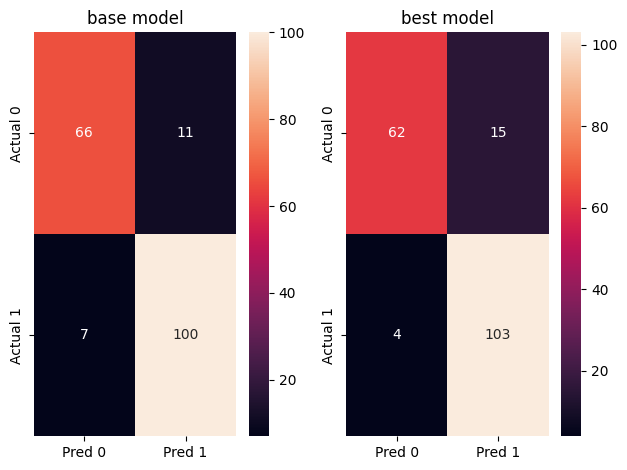

In [143]:
plt.subplot(1,2,1)
sns.heatmap(cm_base,annot=True,fmt='d')
plt.title('base model')
plt.subplot(1,2,2)
sns.heatmap(cm_best,annot=True,fmt='d')
plt.title('best model')
plt.tight_layout()